# File Handling with Manus
> Prerequisites: Complete Notebook 1 and have your MANUS_API_KEY configured.

Now that you've mastered the basics of creating and managing tasks, it's time to give Manus the context it needs to handle more complex, real-world problems. 

Here’s what you'll learn:

1. Direct Uploads: We'll start by uploading a local dataset using the Files API and have Manus analyze it to build a complete, interactive website.
2. URL Attachments: You'll learn how to attach files directly from a URL—no download required—to automate a common business workflow: summarizing a call and drafting follow-up actions.
3. Base64 Encoding: We'll cover how to handle in-memory data, like screenshots, by encoding them as Base64 to create an automated bug investigation and reporting system.

By the end, you'll be able to seamlessly integrate any kind of file into your Manus workflows. 

## Environment Configuration

Let's start with setting up our environment variables

In [5]:
from lib.env import get_base_url, get_env_key

API_KEY = get_env_key()
BASE_URL = get_base_url()

## Working with the Files API

Let's start with the most common pattern: uploading local files directly to Manus.

### Getting our Dataset

First, we need some data to work with. We'll start by fetching character data directly from the public Rick and Morty API and then save it as a local JSON file. This prepares our dataset for the next step: uploading it to Manus.

Let's grab the first 100 characters to keep our dataset manageable.

In [1]:
import requests

# Fetch multiple pages of characters
all_characters = []
base_api_url = "https://rickandmortyapi.com/api/character"

# Fetch first 5 pages (20 characters per page = 100 characters)
for page in range(1, 6):
    response = requests.get(f"{base_api_url}?page={page}")
    response.raise_for_status()
    data = response.json()
    all_characters.extend(data["results"])
    print(f"✓ Fetched page {page}: {len(data['results'])} characters")

print(f"\n✓ Total characters fetched: {len(all_characters)}")

/Users/ivanleo-work/Documents/coding/manus-api-webhook-workshop/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


✓ Fetched page 1: 20 characters
✓ Fetched page 2: 20 characters
✓ Fetched page 3: 20 characters
✓ Fetched page 4: 20 characters
✓ Fetched page 5: 20 characters

✓ Total characters fetched: 100


Now that we have the data in memory, let's save it to a local JSON file.



In [4]:
import os
import json

# Ensure the data directory exists
os.makedirs("./data", exist_ok=True)

# Save to JSON file
filename = "./data/rick_and_morty_characters.json"

with open(filename, "w") as f:
    json.dump(all_characters, f, indent=2)

print(f"✓ Saved {len(all_characters)} characters to {filename}")

✓ Saved 100 characters to ./data/rick_and_morty_characters.json


### Uploading your file

With our local file ready, it's time to upload it to Manus. The process involves two simple steps: first, we tell Manus we want to upload a file to get a secure, one-time upload URL. Second, we send the actual file data to that URL.



In [6]:
# Step 1: Create a file record and get a presigned upload URL
headers = {
    "API_KEY": API_KEY,
    "Content-Type": "application/json"
}

create_file_response = requests.post(
    f"{BASE_URL}/files",
    headers=headers,
    json={"filename": "rick_and_morty_characters.json"}
)
create_file_response.raise_for_status()
file_record = create_file_response.json()

file_id = file_record["id"]
upload_url = file_record["upload_url"]

print("✓ File record created")
print(f"File ID: {file_id}\n")

# Step 2: Upload the file content to the presigned URL
with open(filename, "rb") as f:
    upload_response = requests.put(
        upload_url,
        data=f,
        headers={"Content-Type": "application/json"}
    )
    upload_response.raise_for_status()

print("✓ File uploaded successfully!")
print(f"File ID for task attachment: {file_id}")

✓ File record created
File ID: file-gmkDURp8CH76rcayi9SiZo

✓ File uploaded successfully!
File ID for task attachment: file-gmkDURp8CH76rcayi9SiZo


With our dataset securely uploaded, we can create a task and attach the file using the file_id we just received. 

We'll ask Manus to analyze the character data and build a simple, visually appealing website to display its findings.

In [7]:
from lib.task import create_task, FileIDAttachment

prompt = """Using the attached Rick and Morty character dataset, create a simple, visually appealing website (HTML/CSS/JS) that shows:

1. **Character Appearance Frequency**: A sortable table showing how many episodes each character appears in.
2. **Mortality Report**: A visual breakdown (e.g., a pie chart) of character status (Alive, Dead, Unknown).
3. **Additional Insights**: Any other interesting patterns you notice, like species distribution.

Requirements:
- Make it visually appealing with good CSS styling.
- Use vanilla JavaScript (no frameworks).
- Make tables sortable.
- Save the final website as index.html."""

# Create a typed attachment using the file_id
attachments = [
    FileIDAttachment(
        file_id=file_id,
        filename="rick_and_morty_characters.json"
    )
]

# Create the task using our helper function
task = create_task(
    api_key=API_KEY,
    prompt=prompt,
    agent_profile="manus-1.5",
    base_url=BASE_URL,
    attachments=attachments
)

print("✓ Task created! Manus is building your website...\n")
print(task)

task_id = task["task_id"]
task_url = task["task_url"]
print(f"\nTask ID: {task_id}")
print(f"Task URL: {task_url}")
print(f"\n👉 Visit the URL above to watch Manus work in real-time!")

{"task_id":"2dWhKyTjYLAqe7KChHrxaw", "task_title":"Rick and Morty Character Insights Website Creation", "task_url":"https://manus.im/app/2dWhKyTjYLAqe7KChHrxaw"}
✓ Task created! Manus is building your website...

{'task_id': '2dWhKyTjYLAqe7KChHrxaw', 'task_title': 'Rick and Morty Character Insights Website Creation', 'task_url': 'https://manus.im/app/2dWhKyTjYLAqe7KChHrxaw'}

Task ID: 2dWhKyTjYLAqe7KChHrxaw
Task URL: https://manus.im/app/2dWhKyTjYLAqe7KChHrxaw

👉 Visit the URL above to watch Manus work in real-time!


This website generation task is complex and typically takes 10-15 minutes to complete. 

You can visit the task_url to watch Manus work in real-time and see the final dashboard once it's finished.

### Managing File Lifecycle & Security

Manus is designed with enterprise-grade security and data privacy in mind. When you're finished with a file, you have full control over its lifecycle.

Files are automatically deleted after 48 hours, ensuring your data is not stored indefinitely. Once deleted, the file cannot be referenced in future tasks. 

However, for use cases that demand zero data retention, you can take immediate action.

You can either delete the file directly, or for complete assurance, delete the task itself. Deleting a task will permanently remove the task and all of its associated files, leaving no trace of the data in the Manus system.

In [8]:
# Option 1: Delete just the file
url = f"{BASE_URL}/files/{file_id}"
headers = {"API_KEY": API_KEY}
response = requests.delete(url, headers=headers)
response.raise_for_status()
print(f"✓ File {file_id} deleted from Manus workspace")

✓ File file-gmkDURp8CH76rcayi9SiZo deleted from Manus workspace


## Using URL Attachments

Sometimes you already have your files hosted online—call transcripts, documents, images from services, or data from other APIs. In these cases, there's no need to download and re-upload files. Manus can fetch them directly from their public URLs.

This is especially powerful for automated workflows where files are generated by other systems and just need to be processed. Think of it as giving Manus a direct link to content instead of having to physically hand over files.

Imagine you just finished a sales call, and the transcript is automatically saved to a public URL. 

Your manual follow-up process would typically involve:

1. Reading through the entire transcript.
2. Creating a summary and action items in Notion.
3. Drafting a professional follow-up email in Gmail.
4. Figuring out who needs to be CC'd.

This manual work can take 15-30 minutes per call. With Manus, we can automate the entire flow by simply giving it the URL to the transcript.

### Manus Connectors

Manus Connectors are secure integrations that grant your agent permission to interact directly with your other applications, such as Notion, Gmail, or Slack. 

Setting up a connector is a simple, one-time process where you authorize Manus to access a specific tool. Once connected, you can give your agent access to these tools when creating a task. This allows the agent to move beyond simple analysis and take direct action on your behalf—like creating a new page in your Notion knowledge base, drafting a follow-up email in Gmail, or sending a summary to a Slack channel, enabling true end-to-end workflow automation.

### Attaching the File via URL

First, let's define the URL for our call transcript. Notice that we don't need to download anything—Manus will handle it all.

In [13]:
# Call transcript hosted on GitHub (no download/upload needed!)
transcript_url = "https://raw.githubusercontent.com/ivanleo-manus/manus-api-workshop/refs/heads/main/notebooks/data/transcript.json"

# Verify the URL returns 200 OK
transcript_response = requests.get(transcript_url)
if transcript_response.status_code != 200:
    raise ValueError(f"Failed to access transcript URL: {transcript_url} (HTTP {transcript_response.status_code})")
    

print(f"Call transcript: {transcript_url} (Verified: 200 OK)")

Call transcript: https://raw.githubusercontent.com/ivanleo-manus/manus-api-workshop/refs/heads/main/notebooks/data/transcript.json (Verified: 200 OK)


Now, let's create a detailed prompt that tells Manus exactly what to do with the transcript. We'll ask it to use its connected Notion and Gmail accounts to create a summary and draft a follow-up email.



In [11]:
from datetime import datetime

# Get today's date for the Notion page title
today = datetime.now().strftime("%Y-%m-%d")

# Create the prompt
prompt = f"""
I just finished a sales call and need help with the follow-up. Please review the attached call transcript and perform the following actions:

1. **Update Notion**:
   - Go to my "Call Transcripts" page.
   - Create a new page with the title format: "<counterpart_company_name> {today}".
   - Add a concise summary of key discussion points, action items, and next steps.

2. **Draft Follow-up Email**:
   - In Gmail, draft a professional follow-up email to the main counterpart.
   - Reference the key points we discussed and clearly list the action items.
   - CC all other stakeholders who were mentioned in the call.

Please be professional and ensure all action items are clearly stated with owners and timelines.
"""

We also provide the connector IDs for Notion and Gmail so Manus can take advantage of the connectors we've previously provisioned so that it can gather more context

In [ ]:
from lib.task import create_task, URLAttachment

# Connector IDs for Notion and Gmail
NOTION_CONNECTOR_ID = "9c27c684-2f4f-4d33-8fcf-51664ea15c00"
GMAIL_CONNECTOR_ID = "9444d960-ab7e-450f-9cb9-b9467fb0adda"

# Create task with URL attachment and connectors
task_response = create_task(
    api_key=API_KEY,
    base_url=BASE_URL,
    prompt=prompt,
    agent_profile="manus-1.5",
    attachments=[
        URLAttachment(
            url=transcript_url,
            filename="call_transcript.json"
        )
    ],
    connectors=[NOTION_CONNECTOR_ID, GMAIL_CONNECTOR_ID]
)

task_id = task_response["task_id"]
task_url = task_response["task_url"]

print(
    f"✓ Task created successfully!\n"
    f"Task ID: {task_id}\n"
    f"Task URL: {task_url}\n"
    "Visit the URL above to watch Manus work in real-time!"
)

{"task_id":"4MhbFwuEM7PvcPfuHVP7he", "task_title":"Sales Call Follow-up and Transcript Update", "task_url":"https://manus.im/app/4MhbFwuEM7PvcPfuHVP7he"}
✓ Task created successfully!
Task ID: 4MhbFwuEM7PvcPfuHVP7he
Task URL: https://manus.im/app/4MhbFwuEM7PvcPfuHVP7he
👉 Visit the URL above to watch Manus work in real-time!


This task will typically take 2-5 minutes to complete as Manus fetches the transcript, connects to your Notion to create the page, and then connects to Gmail to draft the follow-up email—automating a half-hour of manual work in minutes.

## Base64 Attachments: In-Memory Data & Screenshots

Finally, let's cover the third method: Base64 encoding. 

This approach is perfect for situations where you have file data in memory—like a screenshot, a generated chart, or a response from another API—and want to send it to Manus without ever saving it to a disk.

The main advantage of Base64 is avoiding intermediate file storage. By encoding the file data directly into a string, you can include it in your API request, making your workflow cleaner and more efficient.

Imagine a user reports that the "Settings" link on your website is broken and provides a screenshot of the 404 error. 

Instead of manually investigating, we can automate the entire process:

1. Analyze the screenshot for clues.
2. Visit the website to reproduce the error.
3. Create a detailed bug report for the development team.

Let's see how Base64 makes this possible.

### Loading the Screenshots

First, we need to load our local screenshot and encode it into a Base64 string. Python's built-in base64 library makes this straightforward.

✓ Screenshot loaded: 104,060 bytes
✓ Base64 encoded: 138,748 characters


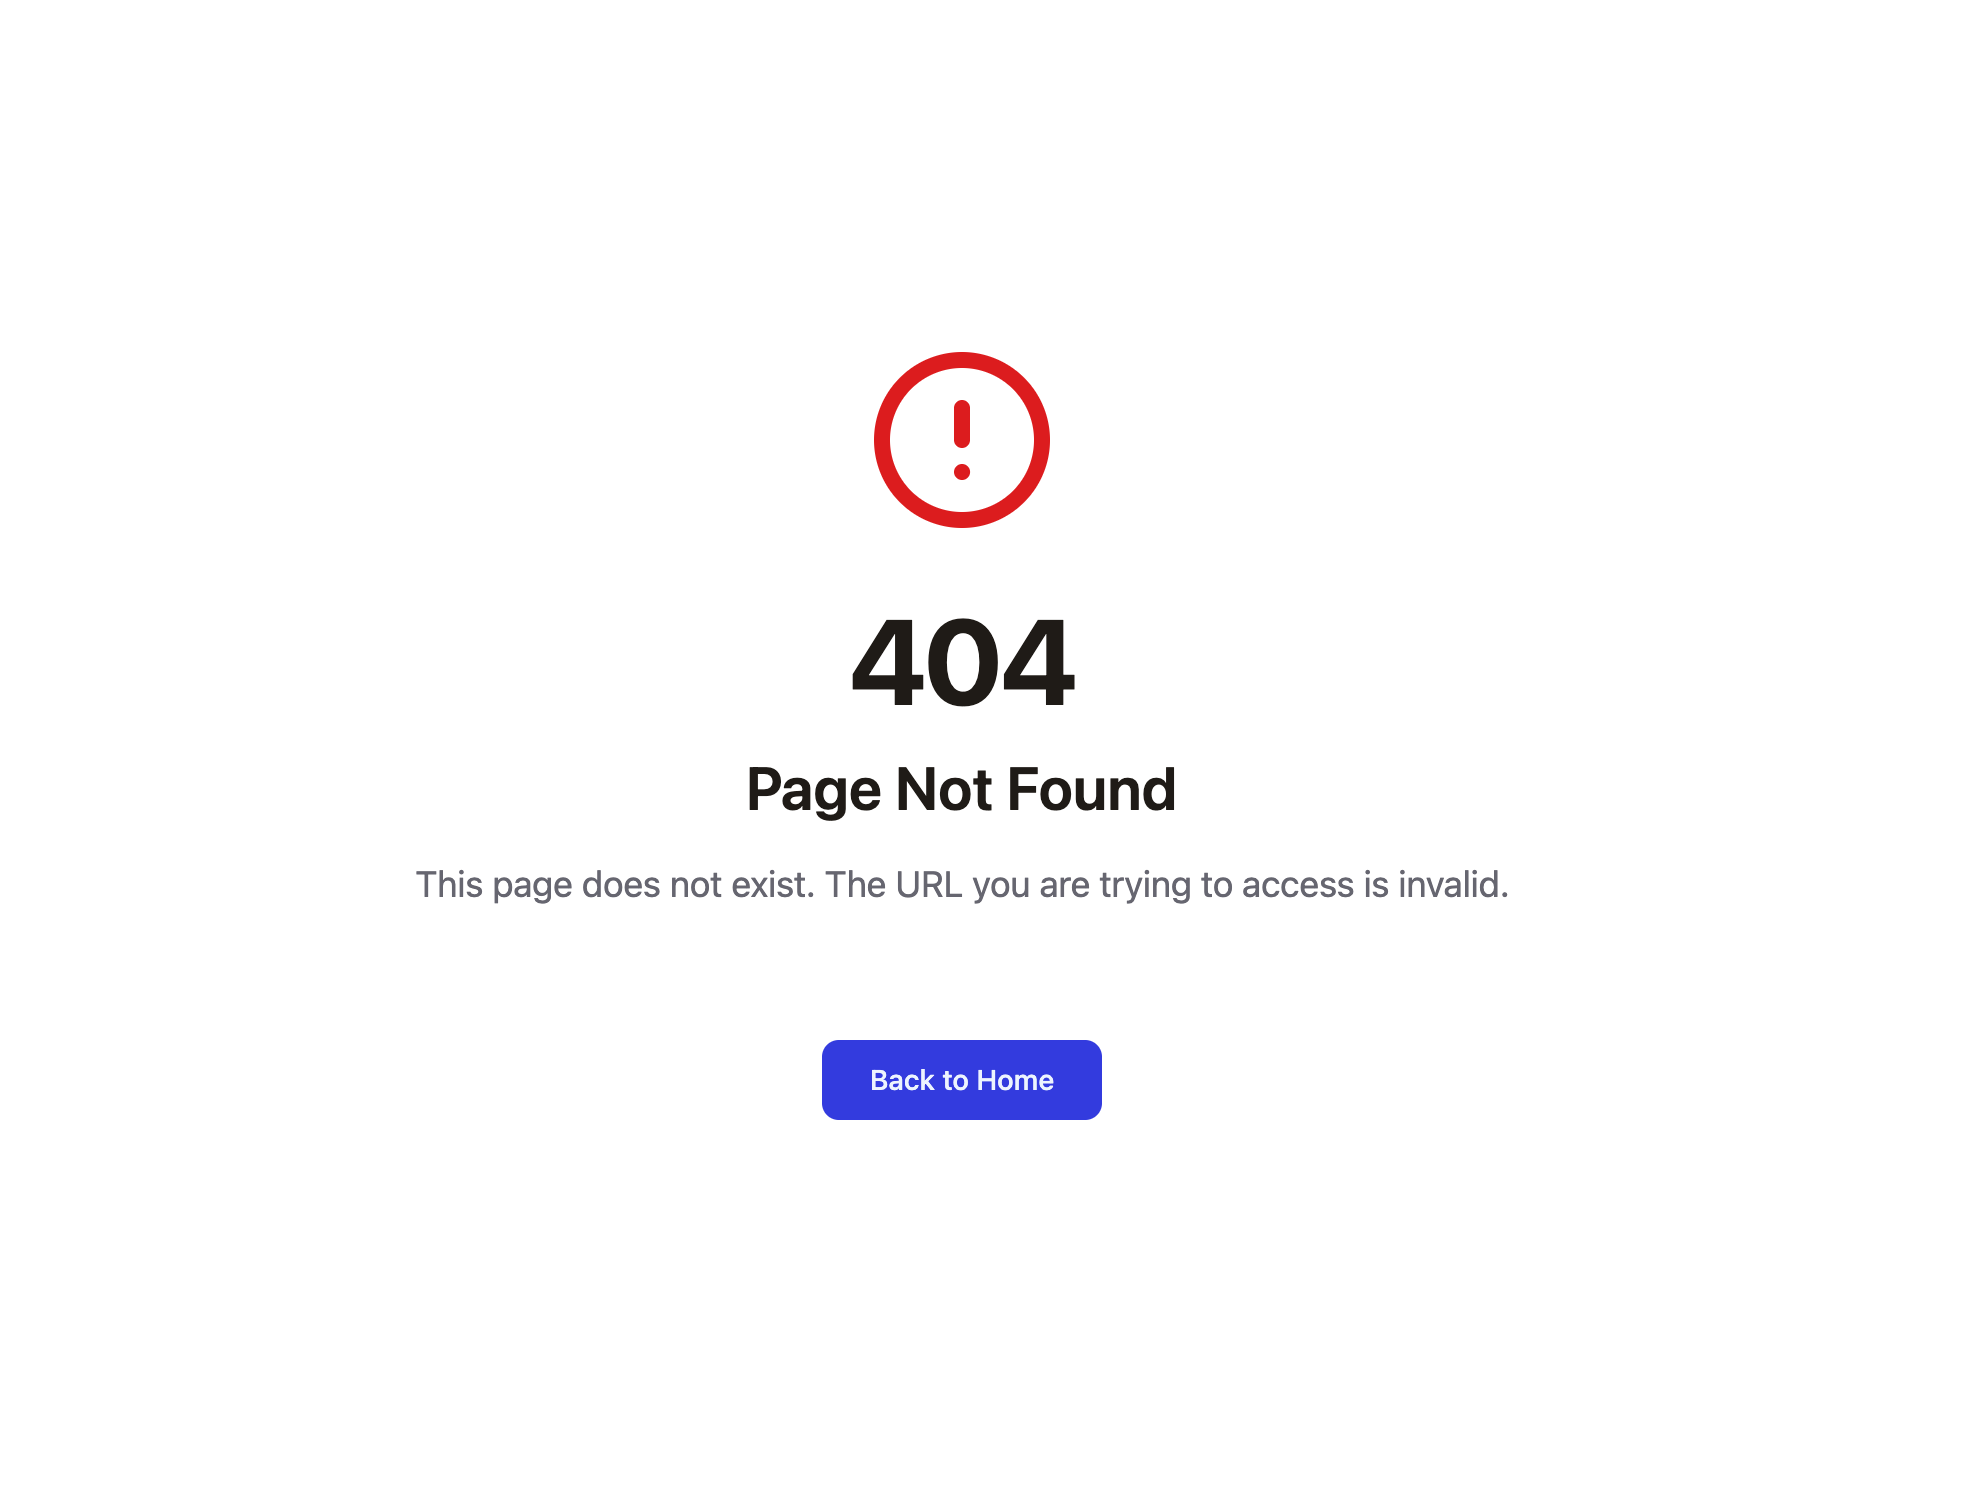

In [14]:
import base64
from IPython.display import Image, display

# Load the screenshot from a local file
screenshot_path = "./data/debug.png"

with open(screenshot_path, "rb") as f:
    image_data = f.read()
    image_base64 = base64.b64encode(image_data).decode('utf-8')

print(f"✓ Screenshot loaded: {len(image_data):,} bytes")
print(f"✓ Base64 encoded: {len(image_base64):,} characters")

# Show a preview of the image
display(Image(data=image_data))

Now we have the entire image represented as a single string, ready to be sent in our API call.

### Creating Automated Bug Investigation Tasks

Next, we'll write a prompt that instructs Manus on how to investigate the bug using the provided screenshot.

In [15]:
prompt = """
A user reported that the Settings page link isn't working on our website. I've attached a screenshot showing a 404 error.

Please help investigate this issue:

1. **Analyze the Screenshot**: Review the attached image to understand the error.
2. **Reproduce the Issue**: Visit https://error404-ek9jbrrv.manus.space/, try to navigate to the Settings page, and document the exact steps that lead to the error.
3. **Create a Bug Report**: Write a detailed report with an issue summary, steps to reproduce, and expected vs. actual behavior. Format it professionally for the development team.

Please be thorough and include all relevant details.
"""

Finally we

In [16]:
from lib.task import create_task, Base64Attachment

# Create the task with a Base64 attachment
bug_task = create_task(
    api_key=API_KEY,
    base_url=BASE_URL,
    prompt=prompt,
    agent_profile="manus-1.5",
    attachments=[
        Base64Attachment(
            file_data=f"data:image/png;base64,{image_base64}",
            filename="user_reported_error.png"
        )
    ]
)

print("✓ Bug investigation task created!\n")
print(f"Task ID: {bug_task['task_id']}")
print(f"Task URL: {bug_task['task_url']}")
print("\n👉 Visit the URL to watch Manus investigate the bug in real-time!")

{"task_id":"5Dhb5Af2kLTwhEXB4sPdmh", "task_title":"Settings Page Link Showing 404 Error", "task_url":"https://manus.im/app/5Dhb5Af2kLTwhEXB4sPdmh"}
✓ Bug investigation task created!

Task ID: 5Dhb5Af2kLTwhEXB4sPdmh
Task URL: https://manus.im/app/5Dhb5Af2kLTwhEXB4sPdmh

👉 Visit the URL to watch Manus investigate the bug in real-time!


In just a few minutes, Manus will analyze the image, reproduce the bug in its own browser, and generate a comprehensive report, saving you 10-15 minutes of manual testing and documentation for every bug report.

## Conclusion

You've now mastered the core file handling patterns of the Manus API.

In this notebook, you learned how to solve real-world problems by:

1. Uploading local files using the Files API for in-depth data analysis and content generation.
2. Attaching files directly from URLs, streamlining workflows by connecting directly to existing web-hosted data.
3. Embedding files using Base64, perfect for handling in-memory data like screenshots in automated debugging tasks.

In the next notebook, we’ll take the final step toward full automation by introducing webhooks. 

You'll learn how to configure Manus to listen for external events—like a new call recording being saved—and automatically kick off the entire follow-up workflow you built here, with zero manual intervention.